<a href="https://colab.research.google.com/github/LCaravaggio/NLP/blob/main/06_clasificaci%C3%B3n/Naive_Bayes.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
import numpy as np


import json
from google.colab import drive

!mkdir ~/.kaggle
!touch ~/.kaggle/kaggle.json

drive.mount('/content/drive', force_remount=True)
with open("/content/drive/My Drive/kaggle.json", 'r') as f:
    api_token= json.load(f)

with open('/root/.kaggle/kaggle.json', 'w') as file:
    json.dump(api_token, file)

!chmod 600 ~/.kaggle/kaggle.json

!kaggle datasets download -d karthickveerakumar/spam-filter

Mounted at /content/drive
  0% 0.00/2.86M [00:00<?, ?B/s]
100% 2.86M/2.86M [00:00<00:00, 205MB/s]


In [2]:
# Extraigo todos los archivos que están en el .zip que acabamos de "bajar".

import zipfile
import os

os.listdir()

for file in os.listdir():
    if file.endswith('.zip'):
      zip_ref = zipfile.ZipFile(file, 'r')
      zip_ref.extractall()
      zip_ref.close()

In [3]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report

In [4]:
df = pd.read_csv('/content/emails.csv')
df.head()

,text,spam
0,Subject: naturally irresistible your corporate...,1
1,Subject: the stock trading gunslinger fanny i...,1
2,Subject: unbelievable new homes made easy im ...,1
3,Subject: 4 color printing special request add...,1
4,"Subject: do not have money , get software cds ...",1


In [5]:
df.text[0]

"Subject: naturally irresistible your corporate identity  lt is really hard to recollect a company : the  market is full of suqgestions and the information isoverwhelminq ; but a good  catchy logo , stylish statlonery and outstanding website  will make the task much easier .  we do not promise that havinq ordered a iogo your  company will automaticaily become a world ieader : it isguite ciear that  without good products , effective business organization and practicable aim it  will be hotat nowadays market ; but we do promise that your marketing efforts  will become much more effective . here is the list of clear  benefits : creativeness : hand - made , original logos , specially done  to reflect your distinctive company image . convenience : logo and stationery  are provided in all formats ; easy - to - use content management system letsyou  change your website content and even its structure . promptness : you  will see logo drafts within three business days . affordability : your  ma

[Text(0, 0, '4360'), Text(0, 0, '1368')]

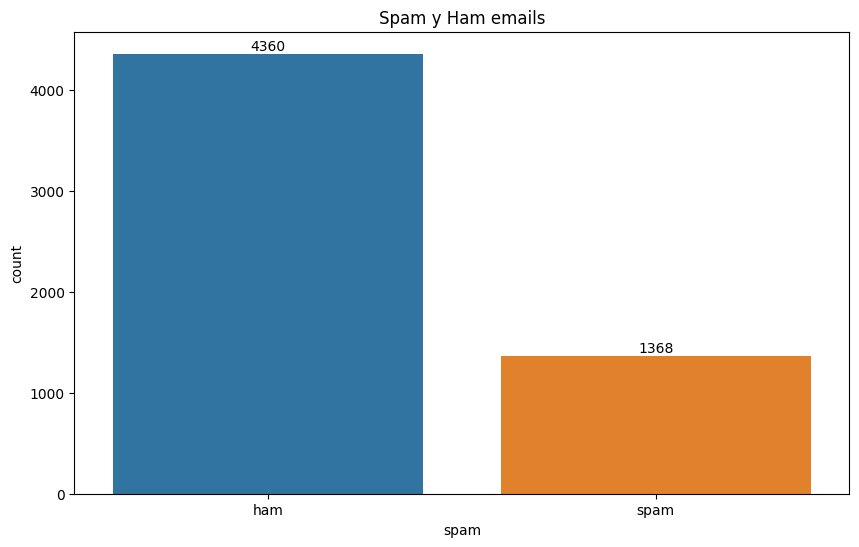

In [8]:
fig = plt.subplots(figsize=(10, 6))
ax = sns.countplot(x='spam', data=df)
ax.set_title('Spam y Ham emails')
ax.set_xticklabels(['ham', 'spam'])
ax.bar_label(ax.containers[0])

In [9]:
df['words'] = df['text'].apply(lambda text: list(set(text.lower().split())))
df.head()

,text,spam,words
0,Subject: naturally irresistible your corporate...,1,"[reflect, logos, recollect, three, naturally, ..."
1,Subject: the stock trading gunslinger fanny i...,1,"[hall, stock, mcdougall, libretto, clockwork, ..."
2,Subject: unbelievable new homes made easy im ...,1,"[way, hearing, your, been, time, at, unconditi..."
3,Subject: 4 color printing special request add...,1,"[e, order, or, mail, 5110, message, &, irwinda..."
4,"Subject: do not have money , get software cds ...",1,"[yet, money, are, !, grow, old, finish, death,..."


In [12]:
df['spam_worded'] = df['spam'].apply(lambda x: 'spam' if x == 1 else 'ham')
df.head()

,text,spam,words,spam_worded
0,Subject: naturally irresistible your corporate...,1,"[reflect, logos, recollect, three, naturally, ...",spam
1,Subject: the stock trading gunslinger fanny i...,1,"[hall, stock, mcdougall, libretto, clockwork, ...",spam
2,Subject: unbelievable new homes made easy im ...,1,"[way, hearing, your, been, time, at, unconditi...",spam
3,Subject: 4 color printing special request add...,1,"[e, order, or, mail, 5110, message, &, irwinda...",spam
4,"Subject: do not have money , get software cds ...",1,"[yet, money, are, !, grow, old, finish, death,...",spam


In [13]:
word_frequency = {}

for ind in df.index:
    for word in df['words'][ind]:
        if word not in word_frequency:
#             word_frequency[word] = {'spam': 0, 'ham': 0}
            word_frequency[word] = {'spam': 1, 'ham': 1} # You can start with one of each to prevent division by 0 later on.
        word_frequency[word][df['spam_worded'][ind]] +=1

dict(list(word_frequency.items())[:5])

{'reflect': {'spam': 31, 'ham': 44},
 'logos': {'spam': 50, 'ham': 3},
 'recollect': {'spam': 26, 'ham': 1},
 'three': {'spam': 89, 'ham': 192},
 'naturally': {'spam': 9, 'ham': 8}}

$P(Spam) = \frac{Number \; of \; spam \; emails}{Total \; emails}$
y
$P(Ham) = \frac{Number \; of \; ham \; emails}{Total \; emails}$

In [14]:
Pspam = df[df['spam'] == 1].shape[0] / df.shape[0]
Pham = df[df['spam'] == 0].shape[0] / df.shape[0]
NbSpam = df[df['spam'] == 1].shape[0]
NbHam = df[df['spam'] == 0].shape[0]

In [19]:
print(Pspam)
print(Pham)
print(NbSpam)
print(NbHam)

0.2388268156424581
0.7611731843575419
1368
4360


$\mathbf P(x | Spam) = \mathbf P(x_1 | Spam) \cdot \mathbf P(x_2 | Spam) \cdot \ldots \cdot \mathbf P(x_n | Spam) = \prod_{k = 1}^{n} \mathbf P(x_n | Spam)$


$P(x_i | Spam) = \frac{Number \; of x_i \; in \; Spam \; emails}{Number \; of \; Spam \; emails}$

$\boxed{\mathbf P(Spam | x) = \frac{\mathbf P(Spam) \cdot \mathbf P(x|Spam)}{\mathbf P(x)}}$

$\mathbf P(x) =  \mathbf P(Spam) \cdot \prod_{k = 1}^{n} \mathbf P(x_n | Spam) +  \mathbf P(Ham) \cdot \prod_{k = 1}^{n} \mathbf P(x_n | Ham)$

In [22]:
def predict(email):
    words = set(email.lower().split())
    PxSpam = 1.0
    PxHam = 1.0
    for word in words:
        if word in word_frequency:

            PxSpam *= word_frequency[word]['spam'] / NbSpam

            PxHam *= word_frequency[word]['ham'] / NbHam



    Px = Pspam * PxSpam + Pham * PxHam
    P_Spam_x = Pspam * PxSpam / Px

    return print(f'{round(P_Spam_x*100, 3)}% probabilidad de ser Spam.')

In [23]:
predict('money but when you buy a mansion you can go to the lottery when i go to the beach with my friends we have a lot of fun')

99.31% probabilidad de ser Spam.


In [24]:
X = df.drop(['spam'], axis=1)
y = df['spam']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42)

In [25]:
train_word_frequency = {}
for ind in X_train.index:
    for word in X_train['words'][ind]:
        if word not in train_word_frequency:
            train_word_frequency[word] = {'spam': 1, 'ham': 1}
        train_word_frequency[word][X_train['spam_worded'][ind]] +=1


train_Pspam = y_train.value_counts()[1] / y_train.shape[0]
train_Pham = y_train.value_counts()[0] / y_train.shape[0]
train_NbSpam = y_train.value_counts()[1]
train_NbHam = y_train.value_counts()[0]

# We compute the probability p(Spam|x), and return 1 if the probability is over 0.5, meaning the email is more likely spam than ham, and 0 if it isn't.
def predict_2(words):
    PxSpam = 1.0
    PxHam = 1.0
    for word in words:
        if word in train_word_frequency:
            #P(x|Spam) = Product of propabilities P(x_i|Spam)
            PxSpam *= train_word_frequency[word]['spam'] / train_NbSpam

            #P(x|Ham) = Product of probabilities P(x_i|Ham)
            PxHam *= train_word_frequency[word]['ham'] / train_NbHam

    #P(x) = P(Spam) * Product of propabilities P(x_i|Spam) + P(Ham) * Product of propabilities P(x_i|Ham)
    Px = train_Pspam * PxSpam + train_Pham * PxHam

    #Finaly, P(Spam|x) = P(Spam) * P(x|Spam) / P(x)
    P_Spam_x = train_Pspam * PxSpam / Px

    return 1 if P_Spam_x > 0.5 else 0

y_pred = X_test['words'].apply(predict_2)

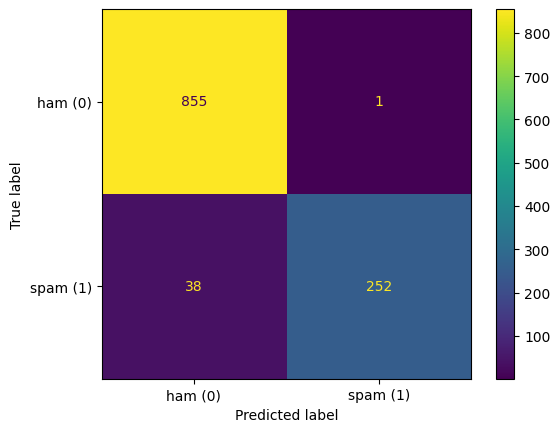

              precision    recall  f1-score   support

     ham (0)       0.96      1.00      0.98       856
    spam (1)       1.00      0.87      0.93       290

    accuracy                           0.97      1146
   macro avg       0.98      0.93      0.95      1146
weighted avg       0.97      0.97      0.97      1146



In [26]:
cm = confusion_matrix(y_test, y_pred)
cmplot = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels = ['ham (0)', 'spam (1)'])
cmplot.plot()
plt.show()

print(classification_report(y_test, y_pred, target_names = ['ham (0)', 'spam (1)']))